# TODO:

Duration: foopsi 7.8 Hz: 5921 s = 98 min

- deconv
 - check fps effects
 - run over multi cells
 - put into pop or cf

- resampling time base issue:
 - resampling: change form explicit 7.825 to retrieving from ogb1 once ogb1 pipeline works
 - get OGB1 in upsampled version (500 Hz) rather than downsample gcamp6f
 
- ds: put into pop or df
 
- ds_ana: see classFun for changes
 - see getgcamp6data TODO: for bar, insert sorted single traces
  - if chirp-stim: 'stim'+Traces = snippets; elif barStim: 'stim'+Traces = transposed/swapaxis version


# Qs:

# Setup

In [1]:
# Library/module setup

# System libs
import sys # system lib
import os # directory lib

# Data libs
import h5py # HDF5 lib
import numpy as np # linear alg lib
import pandas as pd # pandas data structures lib
from pandas import HDFStore
import scipy
import scipy.io
import copy
import time

# Plotting libs
import matplotlib.pyplot as plt # plotting lib
import seaborn as sns # nice plotting lib
from pylab import rcParams
import warnings
import matplotlib.gridspec as gridspec
from __future__ import print_function

# Misc libs
# for integration of plots into jupyter nb
%matplotlib inline

# Custom libs/mods
sys.path.append('../utils/') # Import path to utility function: norm.py, interp.py
import postProc as pop # Import PostProcessing module (functions: normalization, interpolation, QI etc.)
# from norm import norm # normalization function (ensure in same directory)
# from interp import interpNewSRate # interpolation function for resampling trace
try:
    import pycircstat as circ # Phil's & Alex's circular statistics lib (use pip install if not present)
except ImportError:
    !pip install pycircstat
try:
    import peakutils as pk # needed for EulerLab (Andre) classFuncs
except ImportError:
    !pip install peakutils

# sys.path.append('/Volumes/busse_lab/users/yannik/code/retina_analysis/') 
sys.path.append('../../../code/ret_preproc/dataProcessing/Python/postProcessing') # EulerLab (Andre) ret postproc code
sys.path.append('/Volumes/busse_lab/users/yannik/code/ret_preproc/dataProcessing/Python/postProcessing') # EulerLab (Andre) ret postproc code
import classFuncs as cf # Andres function set, import all

In [2]:
# Fig par
plt.style.use('ggplot')

In [3]:
# printOptions = np.get_printoptions()
# np.set_printoptions(threshold=np.nan) # default: 100

In [4]:
# Reload module
import importlib
importlib.reload(pop)

<module 'postProc' from '../utils/postProc.py'>

In [5]:
# Parameter setup
p = {}
p.update({
         # IO pars
        'loadDirRaw': "../../data/2P/raw/gcamp6/", # load directory raw gcamp6f data
        'loadDirProc': "../../data/2P/proc/", # load directory processed data
        'saveDir': "../../data/2P/proc/", # save directory
        'saveFid': "gcamp6Data",# "gcamp6Data_gcamp6fKern_40Hz.h5", # save as HDF5 file
        'savefileFmt': '.h5',
        'dtype': 'Pre', # work on preprocessed data (hdf5)
        
        # Choose what ogb-1 data to base analysis on
        'fidOgb1': 'BadenEtAl_RGCs_2016_ogb1', # processed OGB-1 file (OGB1 groups)
        'fileFmtOgb1': '.mat', 
        'groupVClu': 'clu', # OPTIONS: 'group', 'clu'
        'deconvMethodO1': 'ogb1Kern', # OPTIONS: 'ogb1Kern', 'foopsi'
        'fps': '7.8Hz',
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus name
        'stimFile': ["Chirps.h5", "DS.h5"], # stimulus file name (NOTE: put same order as 'stim'!)
        
        # Resampling pars
#         'chirpTimesStartStop': [0.0641542168675, 31.8846457831], # actual chirp time in OGB-1 (to clip gcamp6 data)
#         'barTimesStartStop': [0.0, 4.0], # actual bar time in OGB-1 (to clip gcamp6 data)
        'chirpDurGcamp6': 32.782, # approximate mean chirp duration in gcamp6
#         'newSRate': 7.83, # Desired sampling rate in Hz, NOTE: had to change from 7.83 Hz due to mismatch otherwise
        
        
        # Normalization pars
        'normMode': 'meanMax', # OPTIONS: 'meanMax', 'medMax', 'r', 'z' (more options, see postProc.py)
        
        # Deconvolution pars
        'deconvMethod': 'gcamp6fKern', # OPTIONS: 'gcamp6fKern', 'foopsi'
        
        # Quality index (QI) pars
        'chirpMinQi': 0.45, # Baden2016: 0.45 <> test: 0.2
        'barMinQi': 0.6, # Baden2016: 0.6 <> test: 0.4
    })


# Build file names
p['saveFid'] = p['saveFid']+"_"+p['deconvMethod']+"_"+p['fps']+p['savefileFmt']
p['fidOgb1'] = p['fidOgb1']+"_"+p['groupVClu']+"_"+p['deconvMethodO1']+"_"+p['fps']+p['fileFmtOgb1']
p

{'barMinQi': 0.6,
 'chirpDurGcamp6': 32.782,
 'chirpMinQi': 0.45,
 'deconvMethod': 'gcamp6fKern',
 'deconvMethodO1': 'ogb1Kern',
 'dtype': 'Pre',
 'fidOgb1': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
 'fileFmtOgb1': '.mat',
 'fps': '7.8Hz',
 'groupVClu': 'clu',
 'loadDirProc': '../../data/2P/proc/',
 'loadDirRaw': '../../data/2P/raw/gcamp6/',
 'normMode': 'meanMax',
 'saveDir': '../../data/2P/proc/',
 'saveFid': 'gcamp6Data_gcamp6fKern_7.8Hz.h5',
 'savefileFmt': '.h5',
 'stim': ['chirp', 'bar'],
 'stimFile': ['Chirps.h5', 'DS.h5']}

# Load processed ogb1-data
here, only used for time alignment of gcamp6gf

In [ ]:
ogb1 = scipy.io.loadmat(p['loadDirProc']+p['fidOgb1'])
scipy.io.whosmat(p['loadDirProc']+p['fidOgb1'])

In [ ]:
## Update OGB1 time info
# (.mat files seem to require storage as 2D)
for iStim in p['stim']:
    ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
    ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0] # Get stim duration
    ogb1[iStim+'SRate'] = len(ogb1[iStim+'Time']) / ogb1[iStim+'Dur']
    print(ogb1[iStim+'Dur'])

# Function: direction selectivity (DS)

In [ ]:
def ds_ana(traces):
    """
    Summary analysis function for multiple direction selectivity (DS) functions.
    
    TODO: see python classFunc
    - output tracesSort
    """
    
    ## Get DS-stimulus info
    # Direction vector (in degrees)
    _, _, dirs, _ = cf.create_ds_stim()
        
    # Convert dirs to mathematical convention: 0 deg = bar moves left to right
    # As 0 deg currently = top to bottom, etc., this encoding is a shift from convention by 270 deg
    dirs = [((x + 270) % 360) for x in dirs]

    # Convert directions from deg2rad
    dirsRad = np.deg2rad(dirs)

    # Trial idx for same dirs
    dirIdx =[[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]]

    ## Analyse DS
    # Get average response of each ROI per direction
    dsMatrix = np.zeros([traces.shape[0], len(dirIdx), traces.shape[2]])
    for i in range(traces.shape[2]):

        # Normalize trial traces (preserving relative structure between trials)
        # NOT nec for snippets, as these are already normalized!
    #     traces[:,:,i] = traces[:,:,i] - np.median(traces[0:8,:,i], axis=0)
    #     traces[:,:,i] = traces[:,:,i] / np.max(np.abs(np.median(traces[:,:,i], axis=1)))
        
        # Get condition average traces
        dsMatrix[:,:,i] = cf.avg_matrix(traces[:,:,i], grouping=dirIdx)

        # Order responses by direction condition
        dsMatrix[:,:,i] = dsMatrix[:, np.argsort(dirsRad), i]

        # Normalize avg matrix
        dsMatrix[:,:,i] = (dsMatrix[:,:,i] - np.median(dsMatrix[0:8,:,i], axis=0))
        dsMatrix[:,:,i] = dsMatrix[:,:,i] / np.max(np.abs(np.median(dsMatrix[:,:,i], axis=1)))

    # Sort trial traces by condition    
    tracesSort = traces[:,dirIdx,:] # (40, 8, 3, 23) (time, condition, trial, roi)
    tracesSort = tracesSort[:,np.argsort(dirsRad),:,:]

    # Sort direction condition
    dirsRad = np.sort(dirsRad)

    # Direction selectivity analysis of each ROI
    dsVector  = np.zeros([len(dirIdx), dsMatrix.shape[2]])
    dsIdx = np.zeros([dsMatrix.shape[2]])
    pVal = np.zeros([dsMatrix.shape[2]])
    qVal = np.zeros([dsMatrix.shape[2]])

    for i in range(dsMatrix.shape[2]):    
        # Get DS vector using SVD
        [dsVector[:,i], tc, _] = cf.direction_selectivity(matrix=dsMatrix[:,:,i])

        # Get projection of time-component onto traces using SVD (for tuning significance test)
        tcProj = np.inner(tracesSort[:,:,:,i].T, tc)

        # Get DS index
        dsIdx[i] = circ.resultant_vector_length(alpha=dirsRad, w=dsVector[:,i], d=np.diff(np.sort(dirsRad)[0:2]))

        # Test DS-tuning significance via permutation test
        [pVal[i], qVal[i], _] = cf.testTuning(dirs=dirsRad, counts=tcProj, per=1) # note: per=1: 1st fourier comp
        
    return dsMatrix, dsVector, dsIdx, pVal, qVal

# Function: getGcamp6fData

In [ ]:
def getGcamp6fData(p, iStim, ogb1):
    """
    Summary function calling multiple analysis functions on a recording field file (hdf5).
    INPUT:
    ------
    p : dict
        parameters
    iStim : scalar
        current stim
    ogb1 : dict
        ogb1 data. Used only for time-alignment of gcamp6f data
    OUTPUT:
    ------
    dataTmp : pandas dataframe
        gcamp6f data for current field
    """
    ## Load data
    # Gets single input file of a field for a stimulus
    # NOTE: with-command: for var assignment and automatic closing    
    with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
        data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

    # Get snippets 
    # Snippets = traces time series for whole field [time x trial x ROI]
    snippets = data['Snippets0']

    # Get snippets times
    snippetsTimes = data['SnippetsTimes0']

    # Remove Nans
    snippets = snippets[:, :, np.any(np.any(~np.isnan(snippets), axis=1), axis=0)]
    snippetsTimes = snippetsTimes[:, :, np.any(np.any(~np.isnan(snippetsTimes), axis=1), axis=0)]

    # If Chirp-stim
    if p['stimFile'][iStim] == 'Chirps.h5':
        nSamples = snippets.shape[0]
        ## Clip snippet duration to equal that of OGB1-Data

        # Get median duration of snippets times (as it varies slightly from field to field, and ROI to ROI)
        stimDur = np.median(np.max(snippetsTimes, axis=0) - snippetsTimes[0,:,:])
        # If you find nans, then set stimDur to median gcamp6Chirp-duration
        if np.isnan(stimDur):
            warnings.warn('NaNs in %s-%s-%s' % (p['date'], p['field'], p['stimFile'][iStim]))
            stimDur = p['chirpDurGcamp6'] # hacky! mend tomorrow

        # Calculate sampling rate
        sRate = nSamples / stimDur

        # Find start and end point to clip (in samples)
        start = int(np.floor(ogb1['chirpTime'][0] * sRate))
        stop = int(np.floor(ogb1['chirpTime'][-1] * sRate))

        # Clip gcamp6 snippets and snippetTimes to duration of ogb1
        snippets = snippets[start:stop]
        snippetsTimes = snippetsTimes[start:stop]

    ## Resample so that nSamplesGcamp6 = nSamplesOgb1
    ogb1SRate = ogb1[p['stim'][iStim]+'SRate'] # 7.825
    ogb1StimDur = ogb1[p['stim'][iStim]+'Dur']
    snippets = pop.interpNewSRate(snippets, ogb1SRate, ogb1StimDur)
#     snippets = pop.interpNewSRate(snippets, p['newSRate'], ogb1StimDur)
    
    ## Normalize and get snippet means/med & sds
    # NOTE: snippets should already be normalized
    snippets = pop.normalize(snippets, mode='meanMax') # normalize for mean (mode: cf. methods Baden2016)
    snippetsMean = np.mean(snippets, axis=1)
    snippetsSd = np.std(snippets, axis=1)

    snippets = pop.normalize(snippets, mode='medMax') # normalize for median (mode: cf. methods Baden2016)    
    snippetsMed = np.median(snippets, axis=1)

    ## Deconvolution 
    # Get mean deconvolved trace per ROI
    deconvTraces = np.zeros((snippets.shape[0], snippets.shape[1], snippets.shape[2])) 
    deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
    deconvSd = np.zeros((snippets.shape[0], snippets.shape[2]))
    for iRoi in range(snippets.shape[2]):
        d, traceSm = pop.deconv(snippets[:,:,iRoi], fps=ogb1SRate, method=p['deconvMethod'], smooth=True, norm=True)
        # Get normalized trace
        deconvTraces[:,:,iRoi] = pop.normalize(d, mode='meanR') # (mean) range norm due to non-negativity of firing rates
        # Get mean and sd
        deconvMean[:,iRoi] = np.mean(deconvTraces[:,:,iRoi], axis=1)
        deconvSd[:,iRoi] = np.std(deconvTraces[:,:,iRoi], axis=1)
        
    ## Get quality indices (QI)
    # Chirp
    if p['stimFile'][iStim] == 'Chirps.h5':
        qis = pop.qi(snippets)
    # Bar - requires variation: get QI for each direction and take max for each cell
    elif p['stimFile'][iStim] == 'DS.h5':
        dirIdx =[[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]] # Vector of bar directions
        qis = np.zeros((len(dirIdx), snippets.shape[2])) # [nDirections, nRois]
        # Loop through directions
        for i in range(len(dirIdx)):
            qis[i] = pop.qi(snippets[:, dirIdx[i], :])
        # Take max of QIs as QI for each ROI
        qis = np.max(qis, axis=0)

    ## For DS/bar-stimulus, do direction selectivity (DS) analysis
    if p['stimFile'][iStim] == 'DS.h5':
            dsMatrix, dsVector, dsIdx, dsPVal, _ = ds_ana(snippets)        
    #         try:
    #             [dsIdx, dsPVal, _] = ds(snippets)
    #         except: # Assign nans
    #             dsIdx, dsPVal = np.empty((snippets.shape[2],1))*np.nan, np.empty((snippets.shape[2],1))*np.nan

    ## Get cell soma areas
    # Get ROI mask
    rois = data['ROIs']
    # Get areas
    areas, _ = cf.roi_area(rois)   

    ## Insert data into temp df
    # NOTE: for traces, consider sth like pd.Series(list(np.swapaxes(dsMatrix.T, 1, 2))) # swap ax to keep [time, trial] order
    dataTmp = pd.DataFrame({
            "date": iDate,
            "field": iField,
            "roi": pd.Series(range(1, snippetsMean.shape[1]+1), index=list(range(snippetsMean.shape[1]))),
            # Insert stimulus-specific data, w flexible var names according to stimulus
            p['stim'][iStim]+"Traces": pd.Series(list(snippets.T)), # hack to add 3D array to pd df - check validity
            p['stim'][iStim]+"Mean": pd.Series(list(snippetsMean.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Med": pd.Series(list(snippetsMed.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Sd": pd.Series(list(snippetsSd.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvTraces": pd.Series(list(deconvTraces.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvMean": pd.Series(list(deconvMean.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvSd": pd.Series(list(deconvSd.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Qi": qis, # QI named according to stimulus
            "somaArea": areas, # Soma areas
              })
    # For bar-stim, add DS-info to dataTmp
    if p['stimFile'][iStim] == 'DS.h5':
        # Insert DS info into tmpData
        dataTmp["barCondAvgTraces"] = pd.Series(list(dsMatrix.T)) # swap ax to keep [time, trial] order
        dataTmp["dsVector"] = pd.Series(list(dsVector.T))
        dataTmp["dsi"] = pd.Series(list(dsIdx))
        dataTmp["dsPVal"] = pd.Series(list(dsPVal))

    # Give some summary info
    print("\tgetGcamp6fData(): Getting data for %d rois." % snippets.shape[2]) # [time x trial x ROI]

    return dataTmp

# Data Processing

### Method:
Data storage: date > field > pre > one hdf5 per stimulus, containing 1+ rois.
Data retrieval: call function getGcamp6Data(p) for all fields and collect data into one dataframe

In [ ]:
# Time cell execution
start = time.time()

# get current working dir
print(os.getcwd())

# Initialize data frame for each stimulus
chirpData = pd.DataFrame(columns=['date', 'field', 'roi'])
barData = pd.DataFrame(columns=['date', 'field', 'roi'])

# Get all recording dates (list of data folders (excl hidden files))
dates = [date for date in os.listdir(p['loadDirRaw']) if not date.startswith('.')]
print('dates:', dates)
for iDate in dates:
    p.update({'date': iDate}) # set date dir
    print('Date:', iDate)
    # Get list of recorded fields (excl hidden files))
    fields = [field for field in os.listdir(p['loadDirRaw']+p['date']) if not field.startswith('.')]
    print('Fields:', fields)
    for iField in fields:
        p.update({
                'field': iField, # set field dir
                'dtype': 'Pre', # use preprocessed data
                }) 
        print(' Field', iField)
#         print(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/')

        # Loop through all stimuli of interest
        for iStim, stim in enumerate(p['stimFile']):
            print('  Stimulus:', stim)
#             p.update({'iStim': iStim}) # set current stimulus
            
            if p['stimFile'][iStim] in os.listdir(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'):
                
                # Get gcamp6 data
                dataTmp = getGcamp6fData(p, iStim, ogb1)
                
                # Append data to appropriate stimulus data
                if p['stimFile'][iStim] == 'Chirps.h5':
                    chirpData = chirpData.append(dataTmp, ignore_index=True)
                    
                elif p['stimFile'][iStim] == 'DS.h5':
                    barData = barData.append(dataTmp, ignore_index=True)                    

            else:
                continue

print('DONE.')
dur = (time.time() - start)
print('Duration: %.2f sec = %.2f min' %(dur, dur/60))

In [ ]:
print('DONE.')

## Find and exclude cell number mismatches between stimuli

In [ ]:
data = pd.merge(chirpData, barData, how='inner')

# # Locate mismatches
# data = pd.merge(chirpData, barData, how='outer', indicator=True)
# dataDiffIdx = list(np.where(foo['_merge'] != 'both')[0])
# dataDiff = data.iloc[dataDiffIdx]

In [ ]:
plt.figure(figsize=[12,5])
plt.plot(data['chirpMean'][0])

## Apply QI criteria to filter out cells

NOTE: this should also take care of any traces w NaNs, which will produce a qi = 0 (as per qiFun)

In [ ]:
nCellsOrig = data.index.size # original pre-criterion number of cells
data = data[(data.chirpQi > p['chirpMinQi']) | (data.barQi > p['barMinQi'])]

# Print summary
print('QI-criterion: QI_chirp: %.2f, QI_bar:%.2f' % (p['chirpMinQi'], p['barMinQi']))
print('QI-criterion: keeping %d/%d cells -> %d cells thrown out.' %
      (data.index.size, nCellsOrig, (nCellsOrig - data.index.size)))

# Reset index to reflect new number of cells
data = data.reset_index(drop=True)

# Save data

In [ ]:
# p.update({'saveFid': 'gcamp6Data_gcamp6fKern_40Hz.h5'}) # _foopsi_7.8Hz, gcamp6fKern_40Hz
print('Saving data to:', p['saveDir']+p['saveFid'])

In [ ]:
store = HDFStore(p['saveDir']+p['saveFid']) # create file
store['data'] = data # save data into file
store.close() # close file

# store.put('data', data, format='table', data_columns=True)

# TESTING PLAYGROUND

## DN RF analysis

In [ ]:
# Parameter setup
p = {}
p.update({
         # IO pars
        'loadDirRaw': "../../data/2P/raw/gcamp6/", # load directory raw gcamp6f data
        'loadDirProc': "../../data/2P/proc/", # load directory processed data
        'saveDir': "../../data/2P/proc/", # save directory
        'saveFid': "gcamp6Data",# "gcamp6Data_gcamp6fKern_40Hz.h5", # save as HDF5 file
        'savefileFmt': '.h5',
        'dtype': 'Pre', # work on preprocessed data (hdf5)
        
        # Choose what ogb-1 data to base analysis on
        'fidOgb1': 'BadenEtAl_RGCs_2016_ogb1', # processed OGB-1 file (OGB1 groups)
        'fileFmtOgb1': '.mat', 
        'groupVClu': 'clu', # OPTIONS: 'group', 'clu'
        'deconvMethodO1': 'ogb1Kern', # OPTIONS: 'ogb1Kern', 'foopsi'
        'fps': '7.8Hz',
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus name
        'stimFile': ["Chirps.h5", "DS.h5"], # stimulus file name (NOTE: put same order as 'stim'!)
        
        # Resampling pars
#         'chirpTimesStartStop': [0.0641542168675, 31.8846457831], # actual chirp time in OGB-1 (to clip gcamp6 data)
#         'barTimesStartStop': [0.0, 4.0], # actual bar time in OGB-1 (to clip gcamp6 data)
        'chirpDurGcamp6': 32.782, # approximate mean chirp duration in gcamp6
#         'newSRate': 7.83, # Desired sampling rate in Hz, NOTE: had to change from 7.83 Hz due to mismatch otherwise
        
        
        # Normalization pars
        'normMode': 'meanMax', # OPTIONS: 'meanMax', 'medMax', 'r', 'z' (more options, see postProc.py)
        
        # Deconvolution pars
        'deconvMethod': 'gcamp6fKern', # OPTIONS: 'gcamp6fKern', 'foopsi'
        
        # Quality index (QI) pars
        'chirpMinQi': 0.45, # Baden2016: 0.45 <> test: 0.2
        'barMinQi': 0.6, # Baden2016: 0.6 <> test: 0.4
    })


# Build file names
p['saveFid'] = p['saveFid']+"_"+p['deconvMethod']+"_"+p['fps']+p['savefileFmt']
p['fidOgb1'] = p['fidOgb1']+"_"+p['groupVClu']+"_"+p['deconvMethodO1']+"_"+p['fps']+p['fileFmtOgb1']
p

In [ ]:
def getGcamp6fData(p, iStim, ogb1):
    """
    Summary function calling multiple analysis functions on a recording field file (hdf5).
    INPUT:
    ------
    p : dict
        parameters
    iStim : scalar
        current stim
    ogb1 : dict
        ogb1 data. Used only for time-alignment of gcamp6f data
    OUTPUT:
    ------
    dataTmp : pandas dataframe
        gcamp6f data for current field
    """
    ## Load data
    # Gets single input file of a field for a stimulus
    # NOTE: with-command: for var assignment and automatic closing    
    with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
        data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

    # Get snippets 
    # Snippets = traces time series for whole field [time x trial x ROI]
    snippets = data['Snippets0']

    # Get snippets times
    snippetsTimes = data['SnippetsTimes0']

    # Remove Nans
    snippets = snippets[:, :, np.any(np.any(~np.isnan(snippets), axis=1), axis=0)]
    snippetsTimes = snippetsTimes[:, :, np.any(np.any(~np.isnan(snippetsTimes), axis=1), axis=0)]

    # If Chirp-stim
    if p['stimFile'][iStim] == 'Chirps.h5':
        nSamples = snippets.shape[0]
        ## Clip snippet duration to equal that of OGB1-Data

        # Get median duration of snippets times (as it varies slightly from field to field, and ROI to ROI)
        stimDur = np.median(np.max(snippetsTimes, axis=0) - snippetsTimes[0,:,:])
        # If you find nans, then set stimDur to median gcamp6Chirp-duration
        if np.isnan(stimDur):
            warnings.warn('NaNs in %s-%s-%s' % (p['date'], p['field'], p['stimFile'][iStim]))
            stimDur = p['chirpDurGcamp6'] # hacky! mend tomorrow

        # Calculate sampling rate
        sRate = nSamples / stimDur

        # Find start and end point to clip (in samples)
        start = int(np.floor(ogb1['chirpTime'][0] * sRate))
        stop = int(np.floor(ogb1['chirpTime'][-1] * sRate))

        # Clip gcamp6 snippets and snippetTimes to duration of ogb1
        snippets = snippets[start:stop]
        snippetsTimes = snippetsTimes[start:stop]

    ## Resample so that nSamplesGcamp6 = nSamplesOgb1
    ogb1SRate = ogb1[p['stim'][iStim]+'SRate'] # 7.825
    ogb1StimDur = ogb1[p['stim'][iStim]+'Dur']
    snippets = pop.interpNewSRate(snippets, ogb1SRate, ogb1StimDur)
#     snippets = pop.interpNewSRate(snippets, p['newSRate'], ogb1StimDur)
    
    ## Normalize and get snippet means/med & sds
    # NOTE: snippets should already be normalized
    snippets = pop.normalize(snippets, mode='meanMax') # normalize for mean (mode: cf. methods Baden2016)
    snippetsMean = np.mean(snippets, axis=1)
    snippetsSd = np.std(snippets, axis=1)

    snippets = pop.normalize(snippets, mode='medMax') # normalize for median (mode: cf. methods Baden2016)    
    snippetsMed = np.median(snippets, axis=1)

    ## Deconvolution 
    # Get mean deconvolved trace per ROI
    deconvTraces = np.zeros((snippets.shape[0], snippets.shape[1], snippets.shape[2])) 
    deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
    deconvSd = np.zeros((snippets.shape[0], snippets.shape[2]))
    for iRoi in range(snippets.shape[2]):
        d, traceSm = pop.deconv(snippets[:,:,iRoi], fps=ogb1SRate, method=p['deconvMethod'], smooth=True, norm=True)
        # Get normalized trace
        deconvTraces[:,:,iRoi] = pop.normalize(d, mode='meanR') # (mean) range norm due to non-negativity of firing rates
        # Get mean and sd
        deconvMean[:,iRoi] = np.mean(deconvTraces[:,:,iRoi], axis=1)
        deconvSd[:,iRoi] = np.std(deconvTraces[:,:,iRoi], axis=1)
        
    ## Get quality indices (QI)
    # Chirp
    if p['stimFile'][iStim] == 'Chirps.h5':
        qis = pop.qi(snippets)
    # Bar - requires variation: get QI for each direction and take max for each cell
    elif p['stimFile'][iStim] == 'DS.h5':
        dirIdx =[[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]] # Vector of bar directions
        qis = np.zeros((len(dirIdx), snippets.shape[2])) # [nDirections, nRois]
        # Loop through directions
        for i in range(len(dirIdx)):
            qis[i] = pop.qi(snippets[:, dirIdx[i], :])
        # Take max of QIs as QI for each ROI
        qis = np.max(qis, axis=0)

    ## For DS/bar-stimulus, do direction selectivity (DS) analysis
    if p['stimFile'][iStim] == 'DS.h5':
            dsMatrix, dsVector, dsIdx, dsPVal, _ = ds_ana(snippets)        
    #         try:
    #             [dsIdx, dsPVal, _] = ds(snippets)
    #         except: # Assign nans
    #             dsIdx, dsPVal = np.empty((snippets.shape[2],1))*np.nan, np.empty((snippets.shape[2],1))*np.nan

    ## Get cell soma areas
    # Get ROI mask
    rois = data['ROIs']
    # Get areas
    areas, _ = cf.roi_area(rois)   

    ## Insert data into temp df
    # NOTE: for traces, consider sth like pd.Series(list(np.swapaxes(dsMatrix.T, 1, 2))) # swap ax to keep [time, trial] order
    dataTmp = pd.DataFrame({
            "date": iDate,
            "field": iField,
            "roi": pd.Series(range(1, snippetsMean.shape[1]+1), index=list(range(snippetsMean.shape[1]))),
            # Insert stimulus-specific data, w flexible var names according to stimulus
            p['stim'][iStim]+"Traces": pd.Series(list(snippets.T)), # hack to add 3D array to pd df - check validity
            p['stim'][iStim]+"Mean": pd.Series(list(snippetsMean.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Med": pd.Series(list(snippetsMed.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Sd": pd.Series(list(snippetsSd.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvTraces": pd.Series(list(deconvTraces.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvMean": pd.Series(list(deconvMean.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"DeconvSd": pd.Series(list(deconvSd.T)), # hack to add 2D array to pd df - check validity
            p['stim'][iStim]+"Qi": qis, # QI named according to stimulus
            "somaArea": areas, # Soma areas
              })
    # For bar-stim, add DS-info to dataTmp
    if p['stimFile'][iStim] == 'DS.h5':
        # Insert DS info into tmpData
        dataTmp["barCondAvgTraces"] = pd.Series(list(dsMatrix.T)) # swap ax to keep [time, trial] order
        dataTmp["dsVector"] = pd.Series(list(dsVector.T))
        dataTmp["dsi"] = pd.Series(list(dsIdx))
        dataTmp["dsPVal"] = pd.Series(list(dsPVal))

    # Give some summary info
    print("\tgetGcamp6fData(): Getting data for %d rois." % snippets.shape[2]) # [time x trial x ROI]

    return dataTmp

In [ ]:
### TESTING PARAMETERS ONLY: explicit dir setup
p.update({        
        'date': '20160223', # 20160223, 20160421
        'field': '01', # 01, 22
#         'chirpMinQi': 0.2,
#         'barMinQi': 0.4,    
#         'newSRate': 7.83,
    })
print(p)

iDate = '20160421'
iField = '09'
iStim = 2

# os.chdir(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/') # go into field dir
print(os.getcwd()) # get current working dir

In [ ]:
p['stim'].append('dn') # or use p['stim'] += ['dn']
p['stim']

In [ ]:
p['stimFile'].append('NoiseGC.h5')

In [ ]:
def load_hdf5(file_, dir_):
    with h5py.File(dir_ + file_, 'r') as f:
        return {key:value[:] for key, value in f.items()}

# def load_h5_data(file_name):
#     with h5py.File(file_name,'r') as f:
#         return {key:f[key][:] for key in list(f.keys())}

In [ ]:
p['stimFile'][2]

In [ ]:
dir_load = p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'
dir_load

In [ ]:
file_dn = p['stimFile'][2]
dn = load_hdf5(file_dn, dir_load)
data_noise = dn

In [ ]:
file_chirp = p['stimFile'][0]
data_chirp = load_hdf5(file_chirp, dir_load)
data_chirp

In [ ]:
mask_roi = data_chirp['ROIs']

# mean_image = data_image['wDataCh0'].mean(axis = -1)
# mean_stack = data_stack['wDataCh0'].reshape([512, 512, 2, -1]).mean(axis = 2).mean(axis = 1)
mean_chirp = data_chirp['wDataCh0'].mean(axis = -1)
mean_chirp.shape

In [ ]:
# np.random.seed(2)

n_rois = np.unique(mask_roi).shape[0] - 1

n_subset = n_rois

roi_subset = np.random.choice(n_rois, n_subset, replace = False)

roi_color = sns.color_palette('hls', n_subset)

x, y = mask_roi.shape
rgba_array = np.zeros([x, y, 4])
rgba_array[:] = np.nan

for itx in range(n_subset):
    rgba_array[mask_roi == -roi_subset[itx], :] = list(roi_color[itx]) + [1,]

traces = data_chirp['Snippets0'].mean(axis = 1)
tpnts = data_chirp['SnippetsTimes0'][:, 0, :]
tpnts -= tpnts.min()

In [ ]:
sns.set_style('white')

offset = 6

gs = gridspec.GridSpec(1, 2, width_ratios = [0.4, 0.6])

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

ax0.imshow(mean_chirp, interpolation = 'nearest', cmap = 'viridis')
ax0.imshow(rgba_array, interpolation = 'nearest')

sns.despine(left = True, bottom = True, ax = ax0)
ax0.set_xticklabels([]);
ax0.set_yticklabels([]);
ax0.grid(False)

for itx in range(n_subset):
    plt.plot(
        tpnts[:, roi_subset[itx]], 
        traces[:, roi_subset[itx]] + offset * itx, 
        color = roi_color[itx],
        linewidth = 1
    )

ax1.set_xlim([0, 32])
ax1.set_xlabel('Time (s)')
ax1.set_yticklabels([]);
sns.despine(left = True, ax = ax1)

plt.gcf().set_size_inches(10, 4)

plt.savefig('ROI Traces.pdf')

In [ ]:

## Load data
# Gets single input file of a field for a stimulus
# NOTE: with-command: for var assignment and automatic closing    
with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
    data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

# Get snippets 
# Snippets = traces time series for whole field [time x trial x ROI]
snippets = data['Snippets0']

# Get snippets times
snippetsTimes = data['SnippetsTimes0']

# Remove Nans
# snippets = snippets[:, :, np.any(np.any(~np.isnan(snippets), axis=1), axis=0)]
# snippetsTimes = snippetsTimes[:, :, np.any(np.any(~np.isnan(snippetsTimes), axis=1), axis=0)]


In [ ]:
def upsample_triggers(triggers, interval, rate):
    return np.linspace(
        triggers.min(),
        triggers.max() + interval,
        triggers.shape[0] * rate
    )

def znorm(data):
    return (data - data.mean()) / data.std()

def interpolate_weights(data, triggers, iROI):
    data_interp = sp.interpolate.interp1d(
        data['Tracetimes0'][:, iROI], 
        znorm(data['Traces0_raw'][:, iROI]),
        kind = 'linear'
    ) (triggers) # interp1d outputs function, so this codes evaluates the function directly at triggers

    return data_interp # Removed znorm here

def lag_weights(weights, nLag):
    lagW = np.zeros([weights.shape[0], nLag])
    
    for iLag in range(nLag):
        lagW[iLag: -nLag+iLag, iLag] = weights[nLag:] / nLag
        
    return lagW

In [ ]:
data_noise['Tracetimes0']

In [ ]:
data_noise['Traces0_raw'].shape

In [ ]:
import scipy.io as sio

# ogb1 = sio.loadmat("../../data/2P/raw/"+"BadenEtAl_RGCs_2016_v1.mat") # 
sio.whosmat("../../data/2P/raw/"+"BadenEtAl_RGCs_2016_v1.mat")

In [ ]:
# Get stimulus file
# used OGB-1 data set here, otherwise euler_data/resources/stimuli/noise.h5, where stimulus is in noise['k']
## NOTE: DOES NOT WORK: full of nans and different dimensionality
stim_noise = ogb1['noise_stim']
stim_noise

stimulus = znorm(stim_noise) # stim_noise['k']
stimulus.shape

In [ ]:
# Load DN stimulus [x,y,tPt] = [15,20,1500], presented at 200 ms/frame > 1500*200 = 75 s
stim_noise = load_hdf5('noise.h5', '../../data/stimulus/') #'loadDirRaw': "../../data/2P/raw/gcamp6/", # load directory raw gcamp6f data
stimulus = znorm(stim_noise['k']) # z-normalize it

stimulus = stimulus.reshape(stimulus.shape[0] * stimulus.shape[1], -1)

stimulus = stimulus[:, :1489]
stimulus.shape

In [ ]:
import scipy as sp

In [ ]:
triggers = data_noise['Triggertimes'] - 0.4
triggers.shape

In [ ]:
np.diff(triggers).min()

In [ ]:
np.diff(triggers).max()

In [ ]:
### sampling issues

triggers = data_noise['Triggertimes'] - 0.43
print(triggers)

## OPTION 1
# triggers = upsample_triggers(
#     data_noise['Triggertimes'], 
#     0.2,
#     1
# ) - 0.4

## OPTION 2
# triggers = data_noise['Triggertimes'] - 0.4 # need to cut off 2 frames (200 ms/frame) to acocunt for convolution

## OPTION 3: add last missing frames
# trig_ext = np.linspace(triggers.max() + 1 * np.mean(np.diff(triggers)),
#                 triggers.max() + (stimulus.shape[1] - triggers.shape[0]) * np.mean(np.diff(triggers)),
#                 stimulus.shape[1] - triggers.shape[0])
# print(trig_ext)
# triggers = np.concatenate((triggers, trig_ext))
triggers.shape


## OPTION 4: interpolate frames
# triggers = np.linspace(data_noise['Triggertimes'].min(),
#                         data_noise['Triggertimes'].min() + (np.mean(np.diff(triggers)) * 1500),
#                         1500,
#                        ) - 0.4


In [ ]:
plt.scatter(triggers[-100:], np.ones(triggers.shape), s = 0.1, c = 'k')

In [ ]:
# triggers = data_noise['Triggertimes'] - 0.43


sns.kdeplot(np.diff(triggers))

In [ ]:
## Compute spatial and temporal RF
# Here, spatial RF is spike-triggered average(STA), or rather activity-weighted stimulus average
sta_out = []
spatial_out = []
temporal_out = []


for i_roi in roi_subset:
    weights = interpolate_weights(data_noise, triggers,  i_roi)
    print('weights:', weights.shape)
    print('weights:', weights)

    # ??
    lagged_weights = lag_weights(weights, 9)
    print('lagged weights:', lagged_weights.shape)
    print('lagged weights:', lagged_weights)
    
    # Bring stimulus back to original dimensionality
    stimulus = stimulus.reshape(15 * 20, -1) 
    print('stim:', stimulus.shape)
    
    # Compute STA
    sta = stimulus.dot(lagged_weights)
    print('sta:', sta.shape)
    
    sta = sta.reshape(15, 20, -1)
    print('sta:', sta.shape)
    
    sta_out.append(sta)
    
    sta_std = np.std(sta, axis = -1)
    
    spatial_out.append(sta_std)
    
    max_std = np.unravel_index(np.argmax(sta_std), (15, 20))

    max_std_ts = sta[max_std[0], max_std[1], :]
    
    temporal_out.append(max_std_ts)
    
#     plt.imshow(sta_std, cmap = 'viridis', origin = 'lower', interpolation = 'nearest')    
#     plt.show()
#     plt.savefig('sta{0}.png'.format(i_roi))

In [ ]:
plt.imshow(sta_std, cmap = 'viridis', origin = 'lower', interpolation = 'nearest')

In [ ]:
plt.plot(max_std_ts)

In [ ]:
sta_out[0].shape

In [ ]:
# Fit 2D Gaussian to STA
import scipy.optimize as opt

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x = xy[0]
    y = xy[1]
        
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

x = np.linspace(0, 19, 20)
y = np.linspace(0, 14, 15)
x, y = np.meshgrid(x, y)


In [ ]:
initial_guess = (1, 9, 7, 1, 1, 0, 10)

data_initial = twoD_Gaussian([x, y], *initial_guess)

opt_out = []

for sta in sta_out:
    sta_std = np.std(sta, axis=-1)

    popt, pcov = opt.curve_fit(twoD_Gaussian, [x, y], sta_std.flatten(), p0 = initial_guess)

    data_fitted = twoD_Gaussian([x, y], *popt)

    opt_out.append(popt)
    
#     fig, ax = plt.subplots(1, 3)

#     ax[0].imshow(sta_std.reshape(sta_std.shape), origin = 'lower')
#     ax[1].imshow(data_initial.reshape(sta_std.shape), origin = 'lower')
#     ax[2].imshow(data_fitted.reshape(sta_std.shape), origin = 'lower')

#     plt.show()

#     for axis in ax:
#         axis.set_xticklabels([]);
#         axis.set_yticklabels([]);

In [ ]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2)

sd = 2
pixel_size = 20

# Show mean image
ax[0].imshow(mean_chirp, interpolation = 'nearest', cmap = 'viridis')
# Show ROI mask
ax[0].imshow(rgba_array, interpolation = 'nearest')

sns.despine(left = True, bottom = True, ax = ax[0])
ax[0].set_xticklabels([]);
ax[0].set_yticklabels([]);
ax[0].grid(False)

mean_opt = np.vstack(opt_out).mean(axis = 0)
for itx, roi in enumerate(roi_subset):
    ell = Ellipse(
        xy = (opt_out[itx][1], opt_out[itx][2]), 
        width = opt_out[itx][3] * sd * pixel_size + 10, 
        height = opt_out[itx][4] * sd * pixel_size + 7.5, 
        angle = opt_out[itx][5] * 360
    )

    ell.set_edgecolor(roi_color[itx])
    ell.set_facecolor('none')
    ell.set_linewidth(2)

    ax[0].add_artist(ell)
    ax[0].set_xlim([-15, 35])
    ax[0].set_ylim([-15, 35])

# Show mean ellipse
ell = Ellipse(
    xy = (mean_opt[1], mean_opt[2]), 
    width = mean_opt[3] * sd * pixel_size + 10, 
    height = mean_opt[4] * sd * pixel_size + 7.5, 
    angle = mean_opt[5] * 360
)

ell.set_edgecolor('k')
ell.set_facecolor('none')
ell.set_linewidth(2)
ell.set_linestyle('--')

ax[0].add_artist(ell)
ax[0].set_xlim([-15, 35])
ax[0].set_ylim([-15, 35])

tpnts = np.linspace(-1.5, 0, 9)
for itx, roi in enumerate(roi_subset):    
    ax[1].plot(tpnts, temporal_out[itx], color = roi_color[itx])

ax[1].plot(tpnts, np.vstack(temporal_out).mean(axis = 0), color = 'k', alpha = 0.8, linestyle = '--')

sns.despine(left = True, ax = ax[1])
ax[1].set_yticklabels([]);
ax[1].set_xlabel('Time (s)')

plt.tight_layout()

fig.set_size_inches([8, 4])

# plt.savefig('STRF.pdf')

## Save data without applying QI criterion
Avoids needing to re-create the data

In [ ]:
p.update({'saveFid': 'gcamp6Data_c+b_gcamp6fKern_7.8Hz.h5'}) # _foopsi_7.8Hz, gcamp6fKern_40Hz


In [ ]:
p.update({'saveFid': 'gcamp6Data_c+b_gcamp6fKern_7.8Hz.h5'}) # _foopsi_7.8Hz, gcamp6fKern_40Hz
print('Saving data to:', p['saveDir']+p['saveFid'])
store = HDFStore(p['saveDir']+p['saveFid']) # create file
store['chirpData'] = chirpData # save data into file
store['barData'] = barData # save data into file
store.close() # close file

## Load data

In [6]:
# Load gcamp6 data
data = pd.read_hdf(p['saveDir']+p['saveFid'], 'data')

In [7]:
# Load gcamp6 data with separate chirp and bar - avoids having to re-generate data every time
p.update({'saveFid': 'gcamp6Data_c+b_gcamp6fKern_7.8Hz.h5'})
chirpData = pd.read_hdf(p['saveDir']+p['saveFid'], 'chirpData')
barData = pd.read_hdf(p['saveDir']+p['saveFid'], 'barData')

# Merge chirp and bar data
data = pd.merge(chirpData, barData, how='inner')

In [8]:
data

,chirpDeconvMean,chirpDeconvSd,chirpDeconvTraces,chirpMean,chirpMed,chirpQi,chirpSd,chirpTraces,date,field,...,barDeconvSd,barDeconvTraces,barMean,barMed,barQi,barSd,barTraces,dsPVal,dsVector,dsi
0,"[0.182614715746, 0.116743502721, 0.28316401370...","[0.302011176476, 0.186499065661, 0.51234073060...","[[0.307347520304, -0.040183597133, 0.922208806...","[-0.0128713834029, -0.0701261534049, 0.0316880...","[-0.0055380478445, 0.00327161255789, 0.0046195...",0.211864,"[0.0893408663753, 0.133742229913, 0.1877135966...","[[-0.0055380478445, -0.173031743708, 0.2079987...",20160421,02,...,"[0.696818394121, 0.677580020891, 0.61536064068...","[[0.395054509992, 0.501994742287, 0.5897134846...","[0.0437493376413, 0.076314383634, -0.010803922...","[0.0338458518582, 0.0828471658089, -0.03694435...",0.617006,"[0.215549096274, 0.172742665322, 0.24770039458...","[[0.0711159668121, 0.144650490188, 0.218331346...",0.065,"[0.146971650946, 0.0876970024924, 0.7751160815...",0.452632
1,"[0.325063187489, 0.324158052195, 0.30372495482...","[0.212968666694, 0.268537722259, 0.30184821984...","[[0.518569869854, 0.730746779392, 0.2119852988...","[0.0163428830284, 0.0358184910552, 0.014767009...","[0.0268358560717, -0.00443396276105, -0.075572...",0.218517,"[0.0614037576025, 0.131472072242, 0.1798485525...","[[0.0699929400391, 0.300181139935, -0.07557295...",20160421,02,...,"[0.51130076764, 0.44028240964, 0.558149198346,...","[[0.0186439345296, 0.42240547886, 0.9210725304...","[0.10354045776, 0.0111755992338, 0.00603861723...","[0.0509111922869, 0.00438792365739, 0.01140594...",0.595495,"[0.374394191696, 0.368499435544, 0.27248477105...","[[-0.244410639974, -0.135312027597, 0.16198533...",0.165,"[0.0, 0.231973270247, 1.0, 0.876868934888, 0.7...",0.370591
2,"[0.774857747478, 0.31499857479, 0.253135939752...","[0.806227538829, 0.160617109637, 0.34574487039...","[[1.77089849192, 0.272915578203, 0.93416716005...","[0.263065414499, 0.117036775833, -0.1142293890...","[-0.0115443168381, 0.0941046663794, -0.1500605...",0.212062,"[0.587133917878, 0.329692919646, 0.09869447712...","[[0.440606116503, -0.419596640369, -0.29909167...",20160421,02,...,"[1.07375997007, 0.955222979249, 0.878251736624...","[[1.05884284543, 2.1245955388, 1.066469472, 0....","[0.625065162486, 0.598621830249, 0.36242293287...","[0.409827712391, 0.670264994778, 0.09872240142...",0.478542,"[1.30268850752, 1.22874112023, 0.825677408486,...","[[0.186266534985, 1.80979636283, 1.02891301497...",0.440,"[0.574385130794, 0.567965855675, 0.02736227041...",0.298715
3,"[0.477231622062, 0.652626116639, 0.58524028313...","[0.0914570233249, 0.11466755802, 0.28300728157...","[[0.501051903449, 0.446335869893, 0.7376356160...","[-0.0046515860399, 0.31687181415, 0.3430306275...","[0.0509274276231, 0.451522085234, 0.1499291213...",0.226944,"[0.273811316896, 0.427114140754, 0.46342674907...","[[-0.0894439546325, -0.208682111235, 0.1499291...",20160421,02,...,"[1.75090273288, 1.42888838513, 2.08887256223, ...","[[1.46080802235, 1.22814376686, -0.76734659553...","[-0.558740158478, 0.619741775207, 0.8463940117...","[0.0540909292856, 0.376702892775, 0.4248265737...",0.459355,"[2.94722711617, 3.12838347214, 3.86498684477, ...","[[0.301901314121, 0.132716183747, -2.532387150...",0.068,"[1.0, 0.54714070334, 0.492528160389, 0.0, 0.37...",0.365433
4,"[0.41645514229, 0.170836911285, 0.345586910403...","[0.313064753265, 0.380271694082, 0.21308966512...","[[0.0482261196033, -0.0620763575458, 0.0585693...","[0.0779425709691, -0.043909710672, 0.078778398...","[0.380070651544, 0.0231850015068, 0.5508211990...",0.260652,"[0.0776486773086, 0.121334781246, 0.1779242945...","[[0.414684405622, 0.117093804944, 0.5508211990...",20160421,05,...,"[1.04013252454, 0.827153787412, 1.00130403624,...","[[-0.4333820086, -0.496684835138, -0.951728532...","[-0.021519298879, -0.069185011652, -0.08781552...","[0.0481989324313, -0.147930291527, -0.05828840...",0.485719,"[0.759617627754, 0.594425772454, 0.67220796379...","[[0.0799701581096, -0.07997

## Count total nFields, ROIs per field etc.

In [9]:
gcamp6 = data

date: 20160223
 nFields: 15
 nCells: 121
 nCellsPerField: 8.1
  f01: n=3
  f03: n=23
  f04: n=13
  f05: n=11
  f06: n=20
  f07: n=20
  f08: n=9
  f09: n=4
  f10: n=2
  f11: n=3
  f12: n=4
  f13: n=1
  f14: n=1
  f15: n=3
  f16: n=4
date: 20160224
 nFields: 13
 nCells: 64
 nCellsPerField: 4.9
  f01: n=1
  f02: n=6
  f03: n=7
  f04: n=4
  f05: n=6
  f06: n=3
  f07: n=13
  f08: n=3
  f09: n=5
  f10: n=8
  f11: n=6
  f12: n=1
  f13: n=1
date: 20160420
 nFields: 16
 nCells: 51
 nCellsPerField: 3.2
  f01: n=3
  f02: n=5
  f03: n=5
  f04: n=5
  f05: n=3
  f06: n=5
  f07: n=4
  f08: n=4
  f09: n=3
  f10: n=2
  f11: n=1
  f12: n=2
  f13: n=2
  f14: n=3
  f15: n=3
  f16: n=1
date: 20160421
 nFields: 25
 nCells: 345
 nCellsPerField: 13.8
  f01: n=2
  f02: n=4
  f03: n=16
  f04: n=12
  f05: n=13
  f06: n=15
  f07: n=18
  f08: n=16
  f09: n=14
  f10: n=10
  f11: n=23
  f12: n=15
  f13: n=10
  f14: n=11
  f15: n=18
  f16: n=15
  f17: n=14
  f18: n=19
  f19: n=25
  f20: n=12
  f21: n=6
  f22: n=16
  

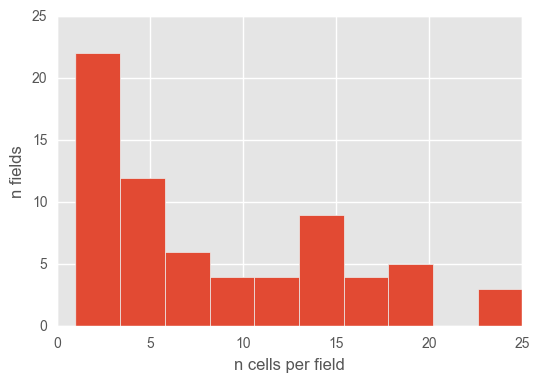

In [38]:
nFieldsTot = 0 # Total nFields counter

cells_per_field_all = []

for i in np.unique(gcamp6.date):
    print('date:', i)
    
    nFields = len(np.unique(gcamp6.field[gcamp6.date == i]))
    print(' nFields:', nFields)
    nFieldsTot += nFields
    
    nCells = len(gcamp6.roi[(gcamp6.date == i)])
    print(' nCells:', nCells)    
    
    nCellsPerField = nCells/nFields
    print(' nCellsPerField: %.1f' % np.round(nCellsPerField,1))
    
    for x in np.unique(gcamp6.field[gcamp6.date == i]):
        cellsInField = len(gcamp6.roi[(gcamp6.date == i) & (gcamp6.field == x)])
        print('  f%s: n=%i' % (x, cellsInField))        
        cells_per_field_all.append(cellsInField)
    
print('\nTotal nFields:', nFieldsTot)
print('Total nCells:', len(gcamp6))
# print('Mean+SD nCellsPerField:', np.round(len(gcamp6)/nFieldsTot, 1))
print('Mean+SD nCellsPerField: %.1f±%.1f' % \
      (np.round(np.mean(cells_per_field_all),1), np.round(np.std(cells_per_field_all),1)))
print('Median nCellsPerField: %.1f' % \
      (np.round(np.median(cells_per_field_all),1)))
print('range nCellsPerField: %i-%i' % \
      (np.min(cells_per_field_all), np.max(cells_per_field_all)))

# Plot histogram of cells per fields by n fields
plt.hist(cells_per_field_all)
plt.xlabel('n cells per field')
plt.ylabel('n fields')

## Export pd df to matlab struct
TODO: make into function df2mat(df, fileDir)

In [ ]:
gcamp6 = data

In [ ]:
## Convert pd df to dict

# Create [cell, time] array rather than single cells for each cell
g6_dict = {col_name : np.array(gcamp6[col_name].values.tolist()) for col_name in gcamp6.columns.values}

# Create cell arrays for cells
# g6_dict = {col_name : gcamp6[col_name].values for col_name in gcamp6.columns.values}

In [ ]:
# Save dict
print('Save to:', p['saveDir']+'gcamp6_data_no_qi.mat')
# sio.savemat(p['saveDir']+'gcamp6_data_no_qi.mat', g6_dict) # Just save dict (> more crowded workspace)
scipy.io.savemat(p['saveDir']+'gcamp6_data_no_qi.mat', {'g6': g6_dict}) # Create single struct w data inside

In [ ]:
# Inspect saved var
viewData = scipy.io.whosmat(p['saveDir']+'gcamp6_data_no_qi.mat')
viewData

## Export pd df to excel

In [ ]:
data.to_excel(p["saveDir"]+'gcamp6Data.xlsx','Sheet1')

## Export pd df to dict

In [ ]:
dataDict = data.to_dict()

In [ ]:
foo = dict(data)
print(foo)

# Test getgcamp6fdata

In [ ]:
# Stop JNB before test section
raise

In [ ]:
### TESTING PARAMETERS ONLY: explicit dir setup
p.update({        
        'date': '20160223', # 20160223, 20160421
        'field': '01', # 01, 22
#         'chirpMinQi': 0.2,
#         'barMinQi': 0.4,    
#         'newSRate': 7.83,
    })
print(p)

iDate = '20160223'
iField = '01'
iStim = 1

# os.chdir(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/') # go into field dir
print(os.getcwd()) # get current working dir

Tricks to try:
 - np.where
 - np.ravel
 - np.roll
 - np.reshape

In [ ]:
p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim]

In [ ]:
with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
    data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

In [ ]:
snippets = data['Snippets0']

# Get snippets times
snippetsTimes = data['SnippetsTimes0']

In [ ]:
print(snippetsTimes.shape)
print(snippetsTimes[0:2,0,:])

In [ ]:
np.max(snippetsTimes, axis=0)

In [ ]:
snippetsTimes[-1] - snippetsTimes[0]

In [ ]:
# Subtract first value from snippetsTimes to align to zero
# NOTE: all snippets are aligned to triggerTime (so technically we could instead subtract triggerTime)
t = snippetsTimes - snippetsTimes[0]
print(t.shape)
print(t[-1,:,:])

In [ ]:
print(ogb1['chirpTime'][0])
print(ogb1['chirpTime'][-1])

In [ ]:
# Clip t to ogb1 times
idx = (t > ogb1['chirpTime'][0]) & (t < ogb1['chirpTime'][-1])
print(idx.shape)
print(idx[0:50,0,0])
print(t[0:50,0,0])
print(idx[-500:-1,0,0])
# print(t[0:50,0,0])

In [ ]:
idx.shape

In [ ]:
t.shape

In [ ]:
(time, trial, roi) = np.where(t > ogb1['chirpTime'][0])
(time, trial, roi)

In [ ]:
t = t[t > ogb1['chirpTime'][0]]
t.shape
np.reshape(t, ) # populate last axis - might have to use rollaxis so that last axis is time vector

In [ ]:
t > ogb1['chirpTime'][0]

In [ ]:
print(time.shape)
print(foo[1].shape)
print(foo[2].shape)

In [ ]:
print(foo[0][0], foo[1][0], foo[2][0])

In [ ]:
t2 = t[idx]
t2.shape

In [ ]:
t2 = t[time, trial, roi]

In [ ]:
snippetsTimes.shape

In [ ]:
np.reshape?

In [ ]:
# def getGcamp6fData(p, iStim, ogb1):
"""
Summary function calling multiple analysis functions on a recording field file (hdf5).
INPUT:
------
p : dict
    parameters
iStim : scalar
    current stim
ogb1 : dict
    ogb1 data. Used only for time-alignment of gcamp6f data
OUTPUT:
------
dataTmp : pandas dataframe
    gcamp6f data for current field
"""
## Load data
# Gets single input file of a field for a stimulus
# NOTE: with-command: for var assignment and automatic closing    
with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
    data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

# Get snippets 
# Snippets = traces time series for whole field [time x trial x ROI]
snippets = data['Snippets0']

# Get snippets times
snippetsTimes = data['SnippetsTimes0']

# Remove Nans
snippets = snippets[:, :, np.any(np.any(~np.isnan(snippets), axis=1), axis=0)]
snippetsTimes = snippetsTimes[:, :, np.any(np.any(~np.isnan(snippetsTimes), axis=1), axis=0)]

# If Chirp-stim
if p['stimFile'][iStim] == 'Chirps.h5':
    nSamples = snippets.shape[0]
    ## Clip snippet duration to equal that of OGB1-Data

    # Get median duration of snippets times (as it varies slightly from field to field, and ROI to ROI)
    stimDur = np.median(np.max(snippetsTimes, axis=0) - snippetsTimes[0,:,:])
    # If you find nans, then set stimDur to median gcamp6Chirp-duration
    if np.isnan(stimDur):
        warnings.warn('NaNs in %s-%s-%s' % (p['date'], p['field'], p['stimFile'][iStim]))
        stimDur = p['chirpDurGcamp6'] # hacky! mend tomorrow

    # Calculate sampling rate
    sRate = nSamples / stimDur

    # Find start and end point to clip (in samples)
    start = int(np.floor(ogb1['chirpTime'][0] * sRate))
    stop = int(np.floor(ogb1['chirpTime'][-1] * sRate))

    # Clip gcamp6 snippets and snippetTimes to duration of ogb1
    snippets = snippets[start:stop]
    snippetsTimes = snippetsTimes[start:stop]

## Resample so that nSamplesGcamp6 = nSamplesOgb1
ogb1SRate = ogb1[p['stim'][iStim]+'SRate'] # 7.825
ogb1StimDur = ogb1[p['stim'][iStim]+'Dur']
snippets = pop.interpNewSRate(snippets, ogb1SRate, ogb1StimDur)
#     snippets = pop.interpNewSRate(snippets, p['newSRate'], ogb1StimDur)

## Normalize and get snippet means/med & sds
# NOTE: snippets should already be normalized
snippets = pop.normalize(snippets, mode='meanMax') # normalize for mean (mode: cf. methods Baden2016)
snippetsMean = np.mean(snippets, axis=1)
snippetsSd = np.std(snippets, axis=1)

snippets = pop.normalize(snippets, mode='medMax') # normalize for median (mode: cf. methods Baden2016)    
snippetsMed = np.median(snippets, axis=1)

## Deconvolution 
# Get mean deconvolved trace per ROI
deconvTrace = np.zeros((snippets.shape[0], snippets.shape[1], snippets.shape[2])) 
deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
deconvSd = np.zeros((snippets.shape[0], snippets.shape[2]))
for iRoi in range(snippets.shape[2]):
    d, traceSm = pop.deconv(snippets[:,:,iRoi], fps=ogb1SRate, method=p['deconvMethod'], smooth=True, norm=True)
    # Get normalized trace
    deconvTrace[:,:,iRoi] = pop.normalize(d, mode='meanR') # range norm due to non-negativity of firing rates (range norm for mean trace)
    # Get mean and sd
    deconvMean[:,iRoi] = np.mean(deconvTrace[:,:,iRoi], axis=1)
    deconvSd[:,iRoi] = np.std(deconvTrace[:,:,iRoi], axis=1)

## Get quality indices (QI)
# Chirp
if p['stimFile'][iStim] == 'Chirps.h5':
    qis = pop.qi(snippets)
# Bar - requires variation: get QI for each direction and take max for each cell
elif p['stimFile'][iStim] == 'DS.h5':
    dirIdx =[[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]] # Vector of bar directions
    qis = np.zeros((len(dirIdx), snippets.shape[2])) # [nDirections, nRois]
    # Loop through directions
    for i in range(len(dirIdx)):
        qis[i] = pop.qi(snippets[:, dirIdx[i], :])
    # Take max of QIs as QI for each ROI
    qis = np.max(qis, axis=0)

## For DS/bar-stimulus, do direction selectivity (DS) analysis
if p['stimFile'][iStim] == 'DS.h5':
        dsMatrix, dsVector, dsIdx, dsPVal, _ = ds_ana(snippets)        
#         try:
#             [dsIdx, dsPVal, _] = ds(snippets)
#         except: # Assign nans
#             dsIdx, dsPVal = np.empty((snippets.shape[2],1))*np.nan, np.empty((snippets.shape[2],1))*np.nan

## Get cell soma areas
# Get ROI mask
rois = data['ROIs']
# Get areas
areas, _ = cf.roi_area(rois)   

## Insert data into temp df
# NOTE: for traces, consider sth like pd.Series(list(np.swapaxes(dsMatrix.T, 1, 2))) # swap ax to keep [time, trial] order
dataTmp = pd.DataFrame({
        "date": iDate,
        "field": iField,
        "roi": pd.Series(range(1, snippetsMean.shape[1]+1), index=list(range(snippetsMean.shape[1]))),
        # Insert stimulus-specific data, w flexible var names according to stimulus
        p['stim'][iStim]+"Traces": pd.Series(list(snippets.T)), # hack to add 3D array to pd df - check validity
        p['stim'][iStim]+"Mean": pd.Series(list(snippetsMean.T)), # hack to add 2D array to pd df - check validity
        p['stim'][iStim]+"Med": pd.Series(list(snippetsMed.T)), # hack to add 2D array to pd df - check validity
        p['stim'][iStim]+"Sd": pd.Series(list(snippetsSd.T)), # hack to add 2D array to pd df - check validity
        p['stim'][iStim]+"DeconvMean": pd.Series(list(deconvMean.T)), # hack to add 2D array to pd df - check validity
        p['stim'][iStim]+"DeconvSd": pd.Series(list(deconvSd.T)), # hack to add 2D array to pd df - check validity
        p['stim'][iStim]+"Qi": qis, # QI named according to stimulus
        "somaArea": areas, # Soma areas
          })
# For bar-stim, add DS-info to dataTmp
if p['stimFile'][iStim] == 'DS.h5':
    # Insert DS info into tmpData
    dataTmp["barCondAvgTraces"] = pd.Series(list(dsMatrix.T)) # swap ax to keep [time, trial] order
    dataTmp["dsVector"] = pd.Series(list(dsVector.T))
    dataTmp["dsi"] = pd.Series(list(dsIdx))
    dataTmp["dsPVal"] = pd.Series(list(dsPVal))

# Give some summary info
print("\tgetGcamp6fData(): Getting data for %d rois." % snippets.shape[2]) # [time x trial x ROI]

#     return dataTmp

In [ ]:
## Deconvolution 
# Get mean deconvolved trace per ROI
deconvTrace = np.zeros((snippets.shape[0], snippets.shape[1], snippets.shape[2])) 
deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
deconvSd = np.zeros((snippets.shape[0], snippets.shape[2]))
for iRoi in range(snippets.shape[2]):
    d, traceSm = pop.deconv(snippets[:,:,iRoi], fps=ogb1SRate, method=p['deconvMethod'], smooth=True, norm=True)
    # Normalize
    deconvTrace[:,:,iRoi] = pop.normalize(d, mode='meanR') # range norm due to non-negativity of firing rates (range norm for mean trace)
    # Get mean and sd
    deconvMean[:,iRoi] = np.mean(d, axis=1)
    deconvSd[:,iRoi] = np.std(d, axis=1)

In [ ]:
snippets.shape

In [ ]:
deconvTrace[:,:,iRoi].shape

In [ ]:
np.mean(deconvTrace[:,:,iRoi])

In [ ]:
plt.plot(np.mean(deconvTrace[:,:,0],  axis=1))

In [ ]:
deconvMean.shape

In [ ]:
plt.plot(deconvMean)

In [ ]:
d.shape

In [ ]:
d.shape

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dataTmp['chirpDeconvMean'][4])

## Create example traces and deconvolution

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dataTmp['chirpDeconvMean'][3])
# plt.plot(dataTmp['chirpMean'][3])

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dataTmp['chirpDeconvMean'][3])
# plt.plot(dataTmp['chirpMean'][3])

In [ ]:
# Reload module
import importlib
importlib.reload(pop)

In [ ]:
snippets.shape

In [ ]:
foo = snippets[:,0,3]
plt.plot(foo)

In [ ]:
d, traceSm = pop.deconv(foo, fps=ogb1SRate, method='ogb1Kern', smooth=True, norm=False)

In [ ]:
plt.plot(d)

## Time cell execution

In [ ]:
import time
time.ctime() # 'Mon Oct 18 13:35:29 2010'
# time.strftime('%l:%M%p %Z on %b %d, %Y') # ' 1:36PM EDT on Oct 18, 2010'
# time.strftime('%l:%M%p %z on %b %d, %Y') # ' 1:36PM EST on Oct 18, 2010'
time.strftime('%l:%M%p')

start = time.time()
print('Duration: %f s' %(start - time.time()))

## Multiprocessing

In [ ]:
from functools import partial
from itertools import repeat
import multiprocessing as mp
from multiprocessing import Pool, freeze_support

nProc = mp.cpu_count()
pool = mp.Pool(processes=nProc)

In [ ]:
for i in enumerate(p['stimFile']):
    print(i)